Essa colab tem por objetivo proporcionar uma limpeza e ajuste dos dados que estão vindo do topsolid.

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [105]:
df = pd.read_csv('data/df_concat.csv')

## FUNÇÕES

In [131]:
'''Essa célula irá armazenar todas as funções de limpeza usadas ao longo do código, contendo na sua descrição o objetivo'''


def ajusta_grain_orientation(elemento):
    """Essa função tem por objetivo padronizar a coluna GRAIN_ORIENTATION, que possui padrões diferentes entre os antigos e novos projetos."""
    if elemento.upper() == 'SIM':
        return -1
    elif elemento.upper() == 'NÃO':
        return 1
    return 'NÃO ENCONTRADO'


def retorna_processo(elemento):
    """Esssa função tem por objetivo trazer o fluxo a uma forma mais simples de ser trabalhada, atuando em cima do processo"""
    if pd.isna(elemento):
        return -1
    elemento = str(elemento)
    return elemento[6:8]


def retorna_maquina(elemento):
    """Esssa função tem por objetivo trazer o fluxo a uma forma mais simples de ser trabalhada, atuando em cima da máquina"""
    if pd.isna(elemento):
        return -1
    elemento = str(elemento)
    return elemento[10:15]


def transforma_lista(elemento):
    """Essa função tem por objetivo padronizar as colunas processos e maquinas, para processos ela definira o formato de lista de inteiros, e para maquinas o formato de lista de strings."""
    lista = []
    for i in elemento.strip().split():
        if i.isnumeric():
            lista.append(int(i))
        else:
            lista.append(i)
    return lista


def limpa_fluxo(lista, maquinas):
    """Essa função tem por objetivo manter no fluxo somente as máquinas que entrarão na classificação."""
    lista_modificada = [num for num in lista if num not in [1, 29, 16, 13, 11, 8, 2, 12]]
    maquinas_modificadas = [maquinas[i] for i in range(len(lista)) if lista[i] not in [1, 29, 16, 13, 11, 8, 2, 12]]
    return lista_modificada, maquinas_modificadas


def retorna_mat_prod(elemento):
    """Essa função tem por objetivo fazer com que as colunas que carregam material e produto como informação mantenham somente o relevante, ignorando o id de cada peça específica."""
    return float(elemento[0:6])

# LIMPEZA DOS DADOS

## IGUALANDO PROJETOS

A primeira coisa a ser relatada é que existem duas versões dos dados, uma que modela os projetos antigos, e a outra que modela os novos projetos. Essa seção tem por objetivo padronizar as mudanças

In [107]:
'''A primeira coisa vista foi que o codigo do produto habita colunas diferentes nas duas versões dos dados, onde na primeira a informação está no campo REFERÊNCIA, e na segunda a informação está no campo CODIGO. Unificaremos no campo CODIGO.'''

df['CODIGO'] = df['CODIGO'].fillna(df['REFERÊNCIA'])

try:
    df = df.drop(columns=['REFERÊNCIA', 'CAM_FILE_NAME']) #A coluna CAM_FILE_NAME é uma repetição de REFERÊNCIA
except:
    df = df.drop(columns=['REFERÊNCIA'])

In [108]:
'''Outro ponto é que na base antiga a oluna grain_orientation vai de -1 a 1, já na nova ela vai de 0 a 1. Vamos padronizar, transformando o valor 0 em -1, faremos isso usando a coluna MATTER_GRAIN_ORIENTATION que possui a mesma informação em formato de string'''

df['GRAIN_ORIENTATION'] = df['MATTER_GRAIN_ORIENTATION'].apply(ajusta_grain_orientation)
df = df.drop(columns=['MATTER_GRAIN_ORIENTATION'])

## AJUSTANDO FLUXO

In [109]:
'''Outro ponto necessário é trazer o fluxo a um padrão mais "trabalhável", dessa forma, sairemos das 7 colunas existentes, com muitos nulos, para apenas duas colunas, sendo essas colunas uma lista de processos (coluna 1) e máquinas (coluna 2).'''

colunas_label = ['CAM_FILE_NAME_0', 'CAM_FILE_NAME_1', 'CAM_FILE_NAME_2', 'CAM_FILE_NAME_3',
                 'CAM_FILE_NAME_4', 'CAM_FILE_NAME_5', 'CAM_FILE_NAME_6']

df['PROCESSOS'] = df[colunas_label].apply(lambda row: ' '.join(str(retorna_processo(elem)) for elem in row if retorna_processo(elem) != -1), axis=1)

df['MAQUINAS'] = df[colunas_label].apply(lambda row: ' '.join(str(retorna_maquina(elem)) for elem in row if retorna_maquina(elem) != -1), axis=1)


df = df.drop(columns=['CAM_FILE_NAME_0', 'CAM_FILE_NAME_1', 'CAM_FILE_NAME_2', 'CAM_FILE_NAME_3','CAM_FILE_NAME_4','CAM_FILE_NAME_5','CAM_FILE_NAME_6'])

In [110]:
'''Além de adiionar o novo formato, iremos transformar cada elemento dentro da lista de processos em um inteiro, e definir para processos e maquinas o formato de uma lista'''

df['PROCESSOS'] = df['PROCESSOS'].apply(transforma_lista)
df['MAQUINAS'] = df['MAQUINAS'].apply(transforma_lista)

In [111]:
'''Vamos também manter no "fluxo" somente os processos que entram para classificação, processos como montagem virarão uma checkbox, pois no fim, são de escolha "pessoal".'''

df['PROCESSOS'], df['MAQUINAS'] = zip(*df.apply(lambda row: limpa_fluxo(row['PROCESSOS'], row['MAQUINAS']), axis=1))

df = df[df['PROCESSOS'].apply(lambda x: len(x) > 0)] #Retirando linhas sem fluxo

## VERIFICANDO INFORMAÇÃO REPETIDA

In [112]:
'''Vamos verificar e excluir (caso haja) colunas repetidas'''

colunas_iguais = []
n = len(df.columns)

for i in range(n):
    for j in range(i + 1, n):
        if df.iloc[:, i].equals(df.iloc[:, j]) and df.columns[i] != df.columns[j]:
            colunas_iguais.append((df.columns[i], df.columns[j]))

In [113]:
colunas_iguais #O print abaixo exibe as colunas repetidas

[('DESCRIÇÃO', 'DESIGNAÇÃO'),
 ('CODIGO_MATERIAL', 'VALORISATION_REFERENCE'),
 ('DESCRIÇÃO_MATERIAL', 'MATERIAL')]

In [114]:
'''Essa célula percorre a informação acima e exclui uma das colunas de cada par de informação repetida.'''

for coluna in colunas_iguais:
    df = df.drop(columns=[coluna[1]])

In [115]:
'''Além disso, as informações das colunas ONE_EDGE_OR_LAMINATE_AXIS_1...ONE_EDGE_OR_LAMINATE_AXIS_6 me parecem não conter muita informação, e a pouca informação parece ser repetida, desse modo elas serão excluídas'''

edges = ['ONE_EDGE_OR_LAMINATE_AXIS_1', 'ONE_EDGE_OR_LAMINATE_AXIS_2',
         'ONE_EDGE_OR_LAMINATE_AXIS_3', 'ONE_EDGE_OR_LAMINATE_AXIS_4',
         'ONE_EDGE_OR_LAMINATE_AXIS_5', 'ONE_EDGE_OR_LAMINATE_AXIS_6']

df = df.drop(columns=edges)

In [116]:
'''Ainda asssim, vamos verificar se não existem colunas que mesmo não sendo identicas, possuem uma alta correspondência'''

limite_percentual = 90

colunas_correspondentes = []

for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
        coluna1 = df.columns[i]
        coluna2 = df.columns[j]
        igualdade_percentual = (df[coluna1] == df[coluna2]).mean() * 100
        if igualdade_percentual >= limite_percentual:
            colunas_correspondentes.append((coluna1, coluna2, igualdade_percentual))

print("Pares de colunas com alta correspondência:")
for par in colunas_correspondentes:
    print(f"{par[0]} e {par[1]} têm {par[2]:.2f}% de correspondência.")

Pares de colunas com alta correspondência:
DESCRIÇÃO e DESCOBRIR têm 99.89% de correspondência.
OP_SUP e FU_SUP têm 93.80% de correspondência.
OP_INF e FU_INF têm 98.62% de correspondência.
OP_LAT e FU_LAT têm 95.63% de correspondência.
OP_LAT e CAV_SUP têm 91.99% de correspondência.
OP_LAT e CAV_INF têm 93.13% de correspondência.
OP_LAT e CAV_LAT têm 93.91% de correspondência.
OP_LAT e FRE_INF têm 91.66% de correspondência.
OP_LAT e FRE_LAT têm 97.14% de correspondência.
FU_LAT e CAV_SUP têm 96.28% de correspondência.
FU_LAT e CAV_INF têm 97.50% de correspondência.
FU_LAT e CAV_LAT têm 97.39% de correspondência.
FU_LAT e FRE_INF têm 95.92% de correspondência.
FU_LAT e FRE_LAT têm 93.65% de correspondência.
CAV_SUP e CAV_INF têm 98.44% de correspondência.
CAV_SUP e CAV_LAT têm 97.77% de correspondência.
CAV_SUP e FRE_INF têm 96.89% de correspondência.
CAV_SUP e FRE_LAT têm 94.61% de correspondência.
CAV_INF e CAV_LAT têm 99.20% de correspondência.
CAV_INF e FRE_SUP têm 90.98% de corres

In [117]:
'''Desse modo, percebemos que não faz sentido manter decrição e descobrir, assim, iremos excluir descobrir. Além disso, vemos que as informações de operação, cavidade e furação possuem uma correspondência muito alta, isso pode ser explorado na hora da modelagem, como por exemplo, reduzir as dimensões para OP, FU E CAV, sem se preocupar o "lado", isso pois, talvez, para o problema de classificar processo, o lado de operação não faça diferença, mas isso é só uma hipótese.'''

df = df.drop(columns=['DESCOBRIR'])

In [118]:
'''Além disso, ao analisar os campos de texto vemos muitas semelhanças
    
    designação+isolante é igual a designação-codigo a única mudança é que o segundo tem informações de dimensão, que já são contempladas em outras colunas
    
    Valorisation_designation é igual a descrição_material, com informações de dimensão
    
    O mesmo acontece com descrição e designação+isolante
'''

df = df.drop(columns=['DESIGNAÇÃO-CODIGO', 'VALORISATION_DESIGNATION', 'DESIGNAÇÃO+ISOLANTE'])

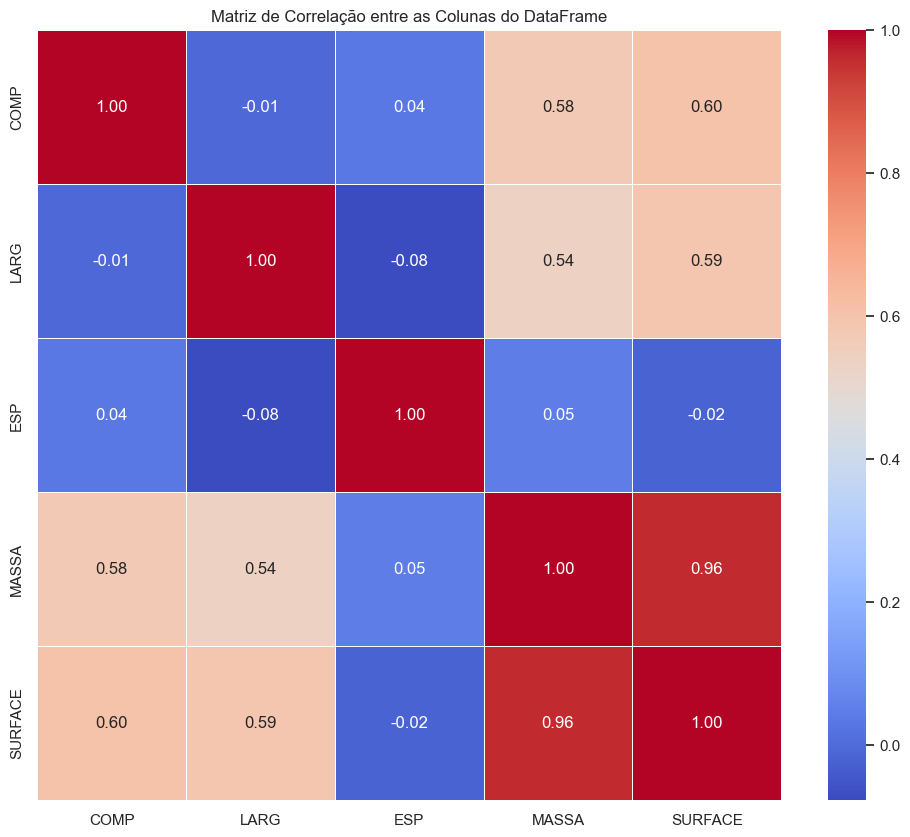

In [125]:
'''Vamos verificar também se temos informação repetida nos campos que envolvem a dimensao da peça'''
dimensao = ['COMP', 'LARG', 'ESP', 'MASSA', 'SURFACE']
dim = df[dimensao]

correlation_matrix = dim.corr()

sns.set(style="white")
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre as Colunas do DataFrame')
plt.show()


In [126]:
'''Com isso, vemos que SURFACE E MASSA possuem uma correlação altíssima, portanto, iremos excluir a coluna surface'''
df = df.drop(columns=['SURFACE'])

## APLICANDO ENCODINGS

In [129]:
'''Aplica label encoder nas colunas binárias'''

colunas_label = ['OP_SUP', 'OP_INF', 'OP_LAT','FU_SUP','FU_INF','FU_LAT', 'CAV_SUP','CAV_INF','CAV_LAT','FRE_SUP','FRE_INF','FRE_LAT', 'RECTANGULAR'] #Aplica label encoder para todas as colunas nesssa lista

label_encoder = LabelEncoder()

for coluna in colunas_label:
    if coluna in df.columns:
        df[coluna] = label_encoder.fit_transform(df[coluna])

In [135]:
'''Ajusta material e produto para ficar somente com o codigo referente a peça em si, ignorando os "ids" de cada prouto e material específico.'''

df['CODIGO_MATERIAL'] = df['CODIGO_MATERIAL'].astype(str).apply(retorna_mat_prod)
df['CODIGO'] = df['CODIGO'].astype(str).apply(retorna_mat_prod)

In [136]:
df

,MOB-B,CODIGO,DESCRIÇÃO,CODIGO_MATERIAL,DESCRIÇÃO_MATERIAL,COMP,LARG,ESP,OP_SUP,OP_INF,...,MACHINING_PROCESSES,RECTANGULAR,MATTER_REFERENCE,MATTER_SUPPLIER,MASSA,GRAIN_ORIENTATION,EDGES_CUT_TYPES,projeto,PROCESSOS,MAQUINAS
0,800.02.00000441 - ARM ALT 3P - SUITE 2-3 1760 F2,850.19,TARUGO DO ARREMATE 1650X30X18MM,100.99,SUCATA,1650.0,30.0,18.0,1,0,...,NaN,1,SUCATO,NaN,666.55,1,NaN,ACQUA_EXEC_7,"[3, 27]","[SEC02, FUR02]"
1,800.02.00000441 - ARM ALT 3P - SUITE 2-3 1760 F2,850.19,REGUA DE MDF 100X1450X18MM,100.99,SUCATA,1450.0,100.0,18.0,0,0,...,NaN,1,SUCATO,NaN,1957.50,1,NaN,ACQUA_EXEC_7,[3],[SEC02]
3,800.02.00000441 - ARM ALT 3P - SUITE 2-3 1760 F2,852.37,PERFIL RM 298,350.10,PERFIL ALUM PORTA REF RM 298 COR PRETO,2425.0,44.0,19.7,0,1,...,NaN,0,NaN,NaN,975.60,1,NaN,ACQUA_EXEC_7,"[3, 21]","[ESQ01, CNC01]"
4,800.02.00000441 - ARM ALT 3P - SUITE 2-3 1760 F2,852.37,PERFIL RM 298,350.10,PERFIL ALUM PORTA REF RM 298 COR PRETO,2425.0,45.0,19.7,1,0,...,Cavidade Aluminio,0,NaN,NaN,969.28,1,NaN,ACQUA_EXEC_7,"[3, 21]","[ESQ01, CNC01]"
5,800.02.00000441 - ARM ALT 3P - SUITE 2-3 1760 F2,852.37,PERFIL RM 298,350.10,PERFIL ALUM PORTA REF RM 298 COR PRETO,2425.0,44.0,19.7,0,0,...,Cavidade Aluminio,0,NaN,NaN,969.28,1,NaN,ACQUA_EXEC_7,"[3, 21]","[ESQ01, CNC01]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,- PERFIL Z FIXO,850.22,PERFIL Z - TRAVA,100.99,SUCATA,500.0,82.0,18.0,0,0,...,NaN,1,SUCATO,NaN,553.50,1,Em esquadria-Em esquadria Em esquadria-Em esqu...,Salinas_Social_5,[3],[SEC02]
7783,- TRAVA TETO,850.26,TRAVA TETO,100.20,COMPENSADO COMUM,800.0,80.0,15.0,0,0,...,NaN,1,Comp comum,NaN,624.00,1,NaN,Salinas_Social_5,[3],[NES01]
7784,- TRAVA TETO,850.26,TRAVA TETO,100.20,COMPENSADO COMUM,600.0,103.0,15.0,1,0,...,NaN,1,Comp comum,NaN,601.98,1,NaN,Salinas_Social_5,[3],[NES01]
7785,- TRAVA TETO,850.26,TRAVA TETO,100.20,COMPENSADO COMUM,232.0,103.0,15.0,0,1,...,NaN,1,Comp comum,NaN,232.60,1,NaN,Salinas_Social_5,[3],[NES01]


In [138]:
df.to_csv('df_prelimpo.csv', index=False)